## **Creating Dataset**

In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split as tts
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier as XGB
import librosa
import librosa.display
import IPython.display as ipd
from tqdm import tqdm

import tensorflow as tf
import keras
from keras.layers import *
from keras.models import *
from keras import backend as K
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import keras.layers as Layers

import warnings
warnings.filterwarnings("ignore")

In [2]:

raw_dataset = './raw dataset/'
csv_path = './mldata.csv'
np_dir = './np_arrays/'
final_dataset = './final_dataset/'

f_start = 101
f_end = 639

labels_df = pd.read_csv(csv_path)

In [3]:
labels = []

for i in range(len(labels_df)):
    crackles = labels_df['crackles'][i]
    wheezes = labels_df['wheezes'][i]
    if crackles==0 and wheezes==0:
        labels.append(0)
    elif crackles and wheezes:
        labels.append(3)
    elif crackles==0 and wheezes!=0:
        labels.append(2)
    elif crackles!=0 and wheezes==0:
        labels.append(1)
    else:
        labels.append(-1)

labels_df['class'] = labels
labels_df = pd.concat([labels_df['patient'], labels_df['crackles'],labels_df['wheezes'],labels_df['class']], axis=1)
labels_df.to_csv(csv_path)

labels_df.head()

,patient,crackles,wheezes,class
0,101,0,11,2
1,102,0,0,0
2,103,0,5,2
3,104,0,2,2
4,105,0,0,0


In [4]:
data_3d = []                                                                    # ran ~ 3 min 30 secs

for patient in range(f_start,f_end+1):
    row = np.load(final_dataset+str(patient)+'.npy')
    data_3d.append(row)

df = pd.DataFrame({'patient':labels_df['patient'], 'features':data_3d, 'class':labels_df['class']})
df.head()

,patient,features,class
0,101,"[[0.0, 0.0, 0.0, -445.4117126464844, 0.0, 0.0,...",2
1,102,"[[0.0, 0.09875842928886414, 1049.1760661583844...",0
2,103,"[[6.0, 0.06401204317808151, 659.8168860261126,...",2
3,104,"[[0.0, 0.0844806358218193, 1117.7693469286253,...",2
4,105,"[[0.0, 0.0, 0.0, -424.2092590332031, 0.0, 0.0,...",0


In [5]:
X = np.asarray(data_3d)
Y = np.asarray(labels_df['class'])

X_train, X_test, Y_train, Y_test = tts(X,Y, test_size=0.3, random_state=42)
X_train, X_val, Y_train, Y_val = tts(X_train,Y_train, test_size=0.25, random_state=42)


X_train = np.asarray(X_train)
X_val = np.asarray(X_val)

In [6]:
OneHot = sklearn.preprocessing.OneHotEncoder()

OneHot.fit(np.reshape(Y_train, (-1,1)))

Y_train_OH = OneHot.transform(np.reshape(Y_train, (-1,1))).toarray()
Y_val_OH = OneHot.transform(np.reshape(Y_val, (-1,1))).toarray()
Y_test_OH = OneHot.transform(np.reshape(Y_test, (-1,1))).toarray()
Y_OH = OneHot.transform(np.reshape(Y, (-1,1))).toarray()

Y_train_OH

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

## **BiLSTM Models**

### Model 1

In [26]:
import pydotplus                        # for plotting models
pydotplus.find_graphviz()

In [47]:
input1 = tf.keras.Input(shape=(862,47))
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,input_shape=(None,862,47),return_sequences=True, dropout=0.01,recurrent_dropout=0.03))(input1)
x2 = tf.keras.layers.Flatten()(x1)
x3 = tf.keras.layers.Dense(1024, activation="relu")(x2)
x5 = tf.keras.layers.Dense(256, activation="relu")(x3)
output1 = tf.keras.layers.Dense(4, activation="sigmoid")(x5)
model1 =keras.Model(inputs=input1, outputs=[output1])

model1.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0005), metrics=['accuracy'])
model1.summary()

tf.keras.utils.plot_model(model1, "./model_imgs/model1.png",show_shapes=True)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 862, 47)]         0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 862, 128)         57344     
 onal)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 110336)            0         
                                                                 
 dense_38 (Dense)            (None, 1024)              112985088 
                                                                 
 dense_39 (Dense)            (None, 256)               262400    
                                                                 
 dense_40 (Dense)            (None, 4)                 1028      
                                                          

### Model 2

In [30]:
class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        super(attention,self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)


input2 = tf.keras.Input(shape=(862,47))
xx1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8,input_shape=(None,862,47),return_sequences=True, dropout=0.2,recurrent_dropout=0.1))(input2)
xx2 = tf.keras.layers.Flatten()(xx1)
xx2 = tf.keras.layers.Dense(512, activation="relu")(xx2)
xx3 = tf.keras.layers.Dense(128, activation="relu")(xx2)
xx4 = tf.keras.layers.Attention()([xx3,xx3])
out2=tf.keras.layers.Dense(4, activation="sigmoid")(xx4)

model2 =keras.Model(inputs=input2, outputs=out2)

model2.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0005), metrics=['accuracy'])
model2.summary()

tf.keras.utils.plot_model(model2, "./model_imgs/model2.png",show_shapes=True)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 862, 47)]    0           []                               
                                                                                                  
 bidirectional_9 (Bidirectional  (None, 862, 16)     3584        ['input_10[0][0]']               
 )                                                                                                
                                                                                                  
 flatten_9 (Flatten)            (None, 13792)        0           ['bidirectional_9[0][0]']        
                                                                                                  
 dense_26 (Dense)               (None, 512)          7062016     ['flatten_9[0][0]']        

### Model 3 : **Bi-LSTM + XGBoost**

In [10]:
input3 = tf.keras.Input(shape=(862,47))
z1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,input_shape=(None,862,47),return_sequences=True, dropout=0.05,recurrent_dropout=0.03))(input3)
z2 = tf.keras.layers.Flatten()(z1)
z3 = tf.keras.layers.Dense(1024, activation="relu")(z2)
z5 = tf.keras.layers.Dense(256, activation="relu")(z3)
output3 = tf.keras.layers.Dense(4, activation="softmax")(z5)
model3 =keras.Model(inputs=input3, outputs=[z3,output3])

model3.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0001), metrics=['accuracy'])
model3.summary()

tf.keras.utils.plot_model(model3, "./model_imgs/model3.png",show_shapes=True)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 862, 47)]         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 862, 128)         57344     
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 110336)            0         
                                                                 
 dense_6 (Dense)             (None, 1024)              112985088 
                                                                 
 dense_7 (Dense)             (None, 256)               262400    
                                                                 
 dense_8 (Dense)             (None, 4)                 1028      
                                                           

In [11]:
features_xgb = model3(X_train)[0]
xgb_model = XGB()
xgb_model.fit(features_xgb, Y_train)
features_test = model3(X)[0]
ypreds = xgb_model.predict(features_test)

print(metrics.accuracy_score(Y, ypreds))

[16:28:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6901669758812616


### Training

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 1.4331 - accuracy: 0.2489
Epoch 00001: saving model to ./raw dataset\weights.h5
8/8 [==============================] - 22s 2s/step - loss: 1.4331 - accuracy: 0.2489 - val_loss: 1.7730 - val_accuracy: 0.2982
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 1.3674 - accuracy: 0.4311
Epoch 00002: saving model to ./raw dataset\weights.h5
8/8 [==============================] - 15s 2s/step - loss: 1.3674 - accuracy: 0.4311 - val_loss: 1.5908 - val_accuracy: 0.3509
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 1.2647 - accuracy: 0.4044
Epoch 00003: saving model to ./raw dataset\weights.h5
8/8 [==============================] - 15s 2s/step - loss: 1.2647 - accuracy: 0.4044 - val_loss: 1.8231 - val_accuracy: 0.2982
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 1.3117 - accuracy: 0.4489
Epoch 00004: saving model to ./raw dataset\weights.h5
8/8 [==============================

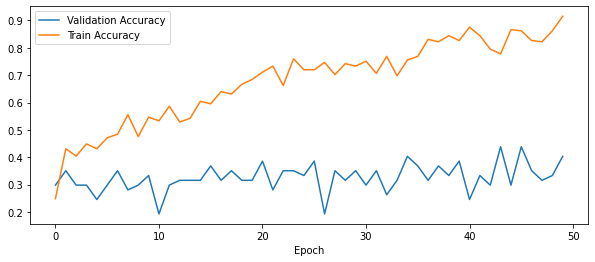

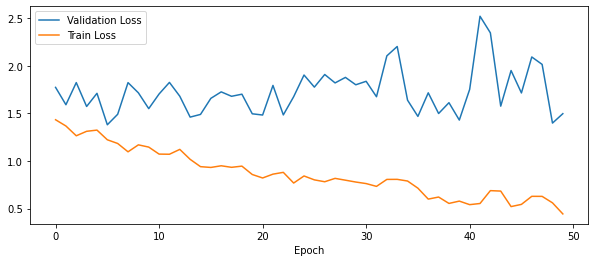

In [49]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(raw_dataset+'weights.h5', monitor='val_accuracy', save_best_only=False, verbose=2)

history = model1.fit(X_train, Y_train_OH,
                    batch_size = 32,
                    epochs = 50,
                    verbose=1,
                    validation_split = 0.2,
                    callbacks=[checkpoint])

loss, accuracy = model1.evaluate(X_test, Y_test_OH, batch_size = 32, verbose=2)

print('\n\nTest loss:', loss)
print('Test accuracy:', accuracy)

dff = pd.DataFrame(history.history)
plt.figure(figsize=(10,4))
plt.plot(range(len(dff['val_accuracy'])), dff['val_accuracy'], label='Validation Accuracy')
plt.plot(range(len(dff['accuracy'])), dff['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(range(len(dff['val_loss'])), dff['val_loss'], label='Validation Loss')
plt.plot(range(len(dff['loss'])), dff['loss'], label='Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

In [50]:
loss1 = loss
acc1 = accuracy
loss1, acc1

(1.0056474208831787, 0.6048237681388855)